<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap14/DepthMapsTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
archive = zipfile.ZipFile('/content/gdrive/My Drive/school_of_ai/chap14/data_Part3.zip')
for file in archive.namelist():
    if file.startswith('Overlay3/Fg-Bg/'):
        archive.extract(file, '/content/')

In [0]:
! ls '/content/Overlay3/Fg-Bg/' | wc -l

80000


In [0]:
#with optimisation
from PIL import Image
a = Image.open("/content/Overlay3/Fg-Bg/fg-bg240001.jpg")

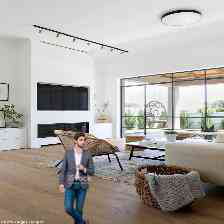

In [0]:
a

In [0]:
cd '/content'

/content


In [0]:
!mkdir Depth_Part3

mkdir: cannot create directory ‘Depth_Part3’: File exists


In [0]:
ls

In [0]:
%cd gdrive/My Drive/school_of_ai/chap14/DepthModel

/content/gdrive/My Drive/school_of_ai/chap14/DepthModel


In [0]:
!git clone https://github.com/seenu-g/DepthModel.git

fatal: destination path 'DepthModel' already exists and is not an empty directory.


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DepthModel/nyu.h5

--2020-05-03 09:38:18--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.102.27
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.102.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DepthModel/nyu.h5’

./DepthModel/nyu.h5 100%[===================>] 164.89M  25.9MB/s    in 9.8s    

2020-05-03 09:38:29 (16.7 MB/s) - ‘./DepthModel/nyu.h5’ saved [172897376/172897376]



In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import notebook

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(path,start,end):
    loaded_images = []
    for i in range(start,end):
        x = np.clip(np.asarray(Image.open(f"{path}fg-bg{str(i)}.jpg" ).resize((448,448)), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True, start = 1):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('gray')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    print(shape)
    
    #all_images = []
    start = start
    for i in notebook.tqdm(range(outputs.shape[0]),desc = f"Loading from {start} images") :
    
        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
  
            #plt.figure(figsize=(2.24,2.24),dpi=100)
            matplotlib_image = plt.imshow(plasma(rescaled)[:,:,:3])
            pil_image = Image.fromarray(np.uint8( ( matplotlib_image.get_array()*255))).convert("L").resize((224,224))
            pil_image.save(f"/content/Depth_Part3/depth{str(start)}.jpg")
            plt.close() 
            start+=1

            # plt.imsave("a.jpg",plasma(rescaled)[:,:,:3])          


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 316801 
for  i in range((320000-316800)//div):

  
  inputs = load_images(path ="/content/Overlay3/Fg-Bg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Using TensorFlow backend.


Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)




Loaded (200) images of size (448, 448, 3).
(224, 224, 3)



done


In [14]:
!ls Depth_Part3/ | wc -l


80000


In [15]:
ls

Depth_Part3/  gdrive/  Overlay3/  sample_data/


In [16]:
from zipfile import ZipFile 
import os 
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = 'Depth_Part3'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    print('Following files will be zipped:') 
    for file_name in file_paths: 
        print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('/content/gdrive/My Drive/school_of_ai/chap14/Depth_Part3.zip','a') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')         
  
main()

Streaming output truncated to the last 5000 lines.
Depth_Part3/depth262181.jpg
Depth_Part3/depth247403.jpg
Depth_Part3/depth291795.jpg
Depth_Part3/depth261142.jpg
Depth_Part3/depth245259.jpg
Depth_Part3/depth296729.jpg
Depth_Part3/depth302756.jpg
Depth_Part3/depth314045.jpg
Depth_Part3/depth242246.jpg
Depth_Part3/depth299317.jpg
Depth_Part3/depth267319.jpg
Depth_Part3/depth240999.jpg
Depth_Part3/depth285326.jpg
Depth_Part3/depth315573.jpg
Depth_Part3/depth260414.jpg
Depth_Part3/depth274637.jpg
Depth_Part3/depth288325.jpg
Depth_Part3/depth311373.jpg
Depth_Part3/depth253264.jpg
Depth_Part3/depth310806.jpg
Depth_Part3/depth266672.jpg
Depth_Part3/depth306076.jpg
Depth_Part3/depth265724.jpg
Depth_Part3/depth307483.jpg
Depth_Part3/depth259721.jpg
Depth_Part3/depth285110.jpg
Depth_Part3/depth292861.jpg
Depth_Part3/depth300783.jpg
Depth_Part3/depth293353.jpg
Depth_Part3/depth244509.jpg
Depth_Part3/depth298009.jpg
Depth_Part3/depth248621.jpg
Depth_Part3/depth305435.jpg
Depth_Part3/depth300001.j